In [1]:
import numpy as np
import pandas as pd 
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from tqdm.notebook import tqdm

__При проведении A/B тестов мы можем влиять на дисперсию, снизив которую мы получим__
1. Снижение шума, которое позволит при меньшем эффекте его задетектировать
2. Меньшее количество наблюдений, что потенциально может быть полезно бизнесу (меньше затрат, меньше времени для того, чтобы набралось достаточное кол-во наблюдений)

### CUPED

__$ Ycuped = Y - \theta X $__
1. $ Ycuped $ - преобразованная метрика 

2. $ Y $ - метрика во время эксперимента 

3. $ \theta $ - $\dfrac{cov(X,Y)}{var(X)}$ 

4. $ {X} $ - ковариата

**В качестве ковариаты обычно берется метрика до проведения эксперимента (в прошлом)**

$ E(Ycuped) $ = $ E(Y - \theta X) $ = $E(Y)  -  E(\theta X) $ $<> E(Y) $ при $ \theta <> 0 $ или $E(X)  <> 0 $ 
_____________________________________________
**Нам необходимо чтобы после трансформации среднее сохранилось, поэтому дополнительно прибавим матожидание выборочного среднего (по методу моментов равны матожиданию)**

Отсюда, можно представить как 
$ E(Ycuped) $ = $ E(Y - \theta X + \theta\bar{X}) $ = $ E(Y) - \theta E(X) + \theta E(\bar{X})  = E(Y) $ 

**Кроме того, можно оценить то, насколько изменится дисперсия**

Пусть у нас есть метрика Y, оценим то, насколько будет изменяться дисперсия.

Исходная дисперсия - ${Var(Y)}$

$ {Var(Ycuped)} = {Var(Y - \theta X)} $  = $ Var(Y) - 2 * cov (\theta X, Y) + Var(\theta X) $ = $ \theta^2 Var(X) + Var(Y) - 2 \theta cov(X, Y) $

Наша задача - минимизация дисперсии, у нас есть две случайные величины - $X$ и $Y$, на них мы влиять никак не можем, а на коэффициент $ \theta $ можем, решим уравнение относительно $\theta $.

___________________________________
$z$  $=$ $ \theta^2 Var(X) + Var(Y) - 2 \theta cov(X, Y) $ - относительно $\theta$ - это парабола, направленная ветвями вверх - минимум будет находится в вершине, отсюда $\thetaв$ = $ 2 * \dfrac{cov(X, Y)}{2 Var(X)}  = \dfrac{cov(X, Y)}{Var(X)} $, поэтому в качестве $\theta$ мы и берем значение равное $\dfrac{cov(X, Y)}{Var(X)}$

___________________________________

Аналогично рассмотрим разницу между тестом и контролем

$ T'  = T - \theta * A$
$ C'  = C - \theta * B$

Рассмотрим разницу между $T' - C' = (T - C) - (\theta * A - \theta * B) $ = $ (T-C) - \theta * (A - B) $

$ \theta = \dfrac{cov(T-C, A-B)}{Var(A-B)} $

Рассмотрим дисперсию величины 

$ {Var(Y - \theta X + \theta\bar X)}$

Пусть $Y- \theta X = b$, тогда

${Var(b+ \theta\bar X)} = Var(b) $, поскольку $\theta\bar X - const$, отсюда 

$ Var(Y- \theta X) = Var(Y - \theta X + \theta\bar X) $ и $ E(Y) = E(Y - \theta X + \theta\bar X) $

1. Есть ли какие-то ограничения на применение CUPED? Необходимость в генерации распределения + валидации разницы средних
2. Как можно перейти от определения CUPED к линейной регресии? При чём тут остатки?
3. Генерация для одной метрики, как меняется среднее и стандартное отклонение, границы применимости (без разницы средних)
4. Как можно дополнительно повлиять на случайные величины? Как может заафектить на бизнес?
5. Дополнительные виды CUPED, подбор гиперпараметров, реализация на синтетических данных.
6. Как можно дополнительно использовать CUPED? Как ведет себя с различными распределениями?

In [2]:
metric = np.random.normal(0, 1, size = 1000000)
metric_before = metric - np.random.uniform(min(metric), max(metric), size = len(metric))
theta = np.cov(metric, metric_before)[0][1] / np.var(metric_before)
metric_cuped = metric - theta * metric_before
metric_cuped_mean = metric_cuped + theta * np.mean(metric_before)

print(f"""
стандартное отклонение для CUPED: {np.std(metric_cuped)},
стандартное отклонение для основной метрики: {np.std(metric)},
стандартное отклонение для CUPED с разницей среднего по ковариате: {np.std(metric_cuped_mean)},
среднее для CUPED: {np.mean(metric_cuped)}
среднее для основной метрики: {np.mean(metric)}
среднее для CUPED с разницей среднего по ковариате: {np.mean(metric_cuped_mean)}""")


стандартное отклонение для CUPED: 0.9400111868069948,
стандартное отклонение для основной метрики: 1.0003186798197028,
стандартное отклонение для CUPED с разницей среднего по ковариате: 0.9400111868069948,
среднее для CUPED: 0.03351021472580495
среднее для основной метрики: -0.00028761490365250504
среднее для CUPED с разницей среднего по ковариате: -0.0002876149036524915


На примере видно, что $CUPED$ с разницей среднего по ковариате не отличается от среднего для основной метрики, а также дисперсия по $CUPED$ не отличиается от дисперсии по $CUPED$ с разницей среднего по ковариате

__Для примера сгенерируем метрику, которая коррелирует с основной. Коэффициент корреляции = 0.8__ 

Для $X1,X2, ... Xn \sim N(0,1) $ найдем метрику, которая соответствует коэффициенту корреляции.

In [3]:
corr = 0.8 # коэффициент корреляции
metric = np.random.normal(0, 1, 1000)
noise = np.random.normal(0, 1, 1000)
covariate = corr * metric + np.sqrt(1 - corr**2) * noise

correlation = np.corrcoef(metric, covariate)[0, 1]
print(f'корреляция - {correlation}')

корреляция - 0.8018235777150517


__Посмотрим, как будет распределена корреляция относительно нескольких симуляций__

In [4]:
corr = 0.8 # коэффициент корреляции
correlations = []
for i in tqdm(range(10000)):
    metric = np.random.normal(0, 1, 1000)
    noise = np.random.normal(0, 1, 1000)
    covariate = corr * metric + np.sqrt(1 - corr**2) * noise
    correlation = np.corrcoef(metric, covariate)[0, 1]
    correlations.append(correlation)


  0%|          | 0/10000 [00:00<?, ?it/s]

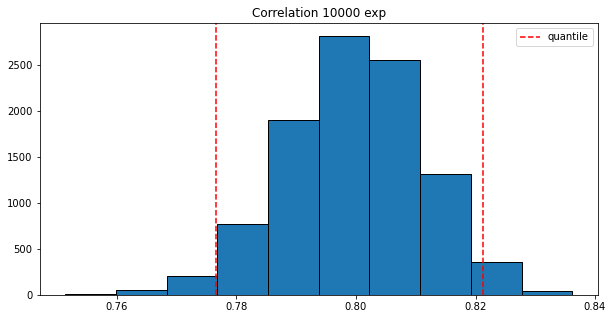

In [5]:
plt.figure(figsize = (10, 5))
plt.hist(correlations, edgecolor = 'black')
plt.title('Correlation 10000 exp')
plt.axvline(np.quantile(correlations, 0.975), c = 'r', label = 'quantile', linestyle = '--')
plt.axvline(np.quantile(correlations, 0.025), c = 'r', linestyle = '--')
plt.legend();
# Корреляция в пределах допустимой, будем считать, что метрика сильно коррелирует с основной

Предположим, что ***metric_before*** коррелирует с основной метрикой

In [6]:
corr = 0.8
metric = np.random.normal(0, 1, size = 10000)
noise = np.random.normal(0, 1, len(metric))
metric_before = corr * metric + np.sqrt(1 - corr**2) * noise
theta = np.cov(metric, metric_before)[0][1] / np.var(metric_before)
metric_cuped = metric - theta * metric_before
metric_cuped_mean = metric_cuped + theta * np.mean(metric_before)

print(f"""
стандартное отклонение для CUPED: {np.std(metric_cuped)},
стандартное отклонение для основной метрики: {np.std(metric)},
стандартное отклонение для CUPED с разницей среднего по ковариате: {np.std(metric_cuped_mean)},
среднее для CUPED: {np.mean(metric_cuped)}
среднее для основной метрики: {np.mean(metric)}
среднее для CUPED с разницей среднего по ковариате: {np.mean(metric_cuped_mean)}""")

# Посмотрим, как меняется стандартное отклонение для CUPED и основной метрики


стандартное отклонение для CUPED: 0.5987564759348014,
стандартное отклонение для основной метрики: 0.9970661715445104,
стандартное отклонение для CUPED с разницей среднего по ковариате: 0.5987564759348014,
среднее для CUPED: 0.0021460483957274194
среднее для основной метрики: -0.008246713591237251
среднее для CUPED с разницей среднего по ковариате: -0.00824671359123725


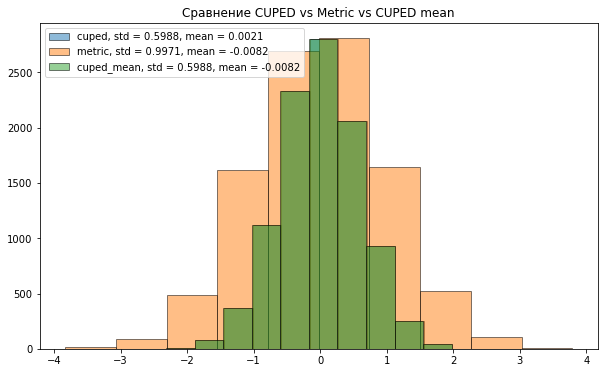

In [7]:
plt.figure(figsize = (10, 6))
plt.title('Сравнение CUPED vs Metric vs CUPED mean')
plt.hist(metric_cuped, edgecolor = 'black', alpha = 0.5, label = f'cuped, std = {np.round(np.std(metric_cuped), 4)}, mean = {np.round(np.mean(metric_cuped), 4)}')
plt.hist(metric, edgecolor = 'black', alpha = 0.5, label = f'metric, std = {np.round(np.std(metric), 4)}, mean = {np.round(np.mean(metric), 4)}')
plt.hist(metric_cuped_mean, edgecolor = 'black', alpha = 0.5, label = f'cuped_mean, std = {np.round(np.std(metric_cuped_mean), 4)}, mean = {np.round(np.mean(metric_cuped_mean), 4)}')
plt.legend()

__На графике наглядно видно, как трансформация метрики влияет на распределение__

1. Без поправки на среднее получаем смещение, но снижаем дисперсию
2. С поправкой на среднее получаем распределение с меньшей дисперсией и таким же матожиданием

#### Посмотрим, как меняется в зависимости от коэффициента корреляции стандартное отклонение для CUPED (можно рассмотреть одну вариацию, т.к. дисперсии одинаковы)

In [8]:
stds_cuped = []
stds_metric = []
step = 0.0001
corrs = np.arange(0, 1 + step, step)
for corr in tqdm(corrs):
    metric = np.random.normal(0, 1, size = 10000)
    noise = np.random.normal(0, 1, len(metric))
    metric_before = corr * metric + np.sqrt(1 - corr**2) * noise
    theta = np.cov(metric, metric_before)[0][1] / np.var(metric_before)
    metric_cuped = metric - theta * metric_before
    metric_cuped_mean = metric_cuped + theta * np.mean(metric_before)
    stds_metric.append(np.std(metric))
    stds_cuped.append(np.std(metric_cuped))

  0%|          | 0/10001 [00:00<?, ?it/s]

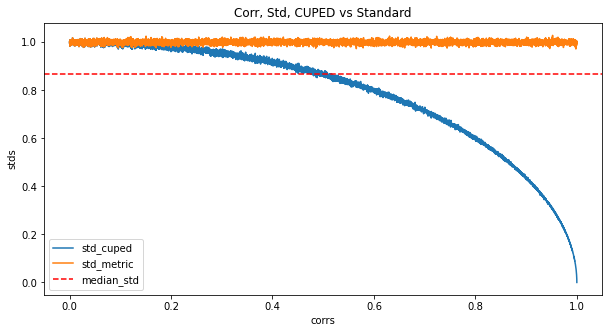

In [9]:
plt.figure(figsize = (10,5))
plt.plot(corrs, stds_cuped, label = 'std_cuped')
plt.plot(corrs, stds_metric, label = 'std_metric')
plt.xlabel('corrs')
plt.ylabel('stds')
plt.title('Corr, Std, CUPED vs Standard')
plt.axhline(np.quantile(stds_cuped, 0.5), c = 'r', linestyle = '--', label = 'median_std')
plt.legend()
plt.show()

# видно, что при CUPED достаточно быстро устремляется стандартное отклонение в 0, CUPED значительно понижает дисперсию
# при нахождении признака, который сильнее всего коррелирует

__Если метрика не стандартизирована__
для $ X1, X2, ... Xn \sim N(20,100) $

In [10]:
sample_size = 1000
corr = 0.8

metric = np.random.normal(20, 100, sample_size)
noise = np.random.normal(0, 100 * np.sqrt(1 - corr**2), sample_size)
metric_before = corr * metric + noise

actual_correlation = np.corrcoef(metric, metric_before)[0, 1]
print(f'корреляция: {actual_correlation}')


корреляция: 0.8023352450778682


In [11]:
corr = 0.7 # коэффициент корреляции
correlations = []
n_experiments = 10000
for i in tqdm(range(n_experiments)):
    metric = np.random.normal(20, 100, 10000)
    noise = np.random.normal(0, 100 * np.sqrt(1 - corr**2), 10000)
    covariate = corr * metric + noise * np.sqrt(1 - corr**2)
    correlation = np.corrcoef(metric, covariate)[0, 1]
    correlations.append(correlation)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
np.corrcoef(metric, covariate)[0][1]

0.8129530606699003

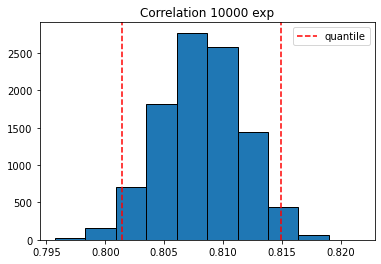

In [13]:
plt.hist(correlations, edgecolor = 'black')
plt.title('Correlation 10000 exp')
plt.axvline(np.quantile(correlations, 0.975), c = 'r', label = 'quantile', linestyle = '--')
plt.axvline(np.quantile(correlations, 0.025), c = 'r', linestyle = '--')
plt.legend();
# Корреляция в пределах допустимой, будем считать, что метрика сильно коррелирует с основной

__Изменение корреляции для нормальной величины с шумом__

In [14]:
stds_cuped = []
stds_metric = []
step = 0.0001
corrs = np.arange(0, 1 + step, step)
for corr in tqdm(corrs):
    metric = np.random.normal(20, 100, 10000)
    noise = np.random.normal(0, 100 * np.sqrt(1 - corr**2), 10000)
    metric_before = corr * metric + noise * np.sqrt(1 - corr**2)
    theta = np.cov(metric, metric_before)[0][1] / np.var(metric_before)
    metric_cuped = metric - theta * metric_before
    metric_cuped_mean = metric_cuped + theta * np.mean(metric_before)
    stds_metric.append(np.std(metric))
    stds_cuped.append(np.std(metric_cuped))

  0%|          | 0/10001 [00:00<?, ?it/s]

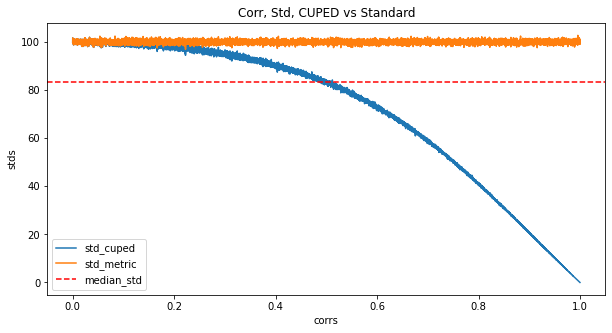

In [15]:
plt.figure(figsize = (10,5))
plt.plot(corrs, stds_cuped, label = 'std_cuped')
plt.plot(corrs, stds_metric, label = 'std_metric')
plt.xlabel('corrs')
plt.ylabel('stds')
plt.title('Corr, Std, CUPED vs Standard')
plt.axhline(np.quantile(stds_cuped, 0.5), c = 'r', linestyle = '--', label = 'median_std')
plt.legend()
plt.show()

# видно, что при CUPED достаточно быстро устремляется стандартное отклонение в 0, CUPED значительно понижает дисперсию
# при нахождении признака, который сильнее всего коррелирует, более линейна в хвосте по сравнению с стандартизированной

__Экспоненциальное распределение__

In [16]:
sample_size = 1000
desired_correlation = 0.8
lambda_param = 1  

E = np.random.exponential(scale=1/lambda_param, size=sample_size)
Z = np.random.exponential(scale=1/lambda_param, size=sample_size)

N_E = np.log(E)
N_Z = np.log(Z)

N_Y = desired_correlation * N_E + np.sqrt(1 - desired_correlation**2) * N_Z

E_prime = np.exp(N_Y)

actual_correlation = np.corrcoef(E, E_prime)[0, 1]
print("Фактическая корреляция: ", actual_correlation)


Фактическая корреляция:  0.7094395895815625


In [17]:
stds_cuped = []
stds_metric = []
step = 0.0001
corrs = np.arange(0, 1 + step, step)
for corr in tqdm(corrs):
    pre_metric = np.random.exponential(scale=1, size = 10000)
    pre_noise = np.random.exponential(scale=1, size = 10000)
    
    metric = np.log(pre_metric)
    noise = np.log(pre_noise)
    
    pre_metric_before = corr * metric + np.sqrt(1 - corr**2) * noise
    
    metric_before = np.exp(pre_metric_before)
    
    theta = np.cov(metric, metric_before)[0][1] / np.var(metric_before)
    metric_cuped = metric - theta * metric_before
    metric_cuped_mean = metric_cuped + theta * np.mean(metric_before)
    stds_metric.append(np.std(metric))
    stds_cuped.append(np.std(metric_cuped))

  0%|          | 0/10001 [00:00<?, ?it/s]

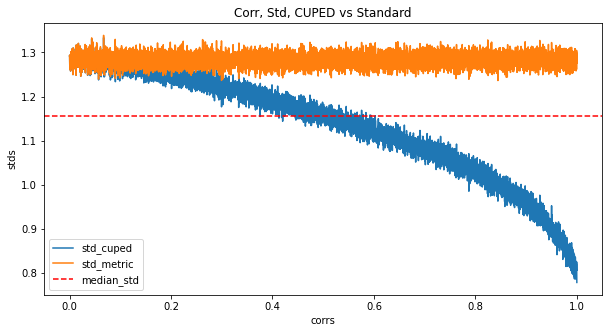

In [18]:
plt.figure(figsize = (10,5))
plt.plot(corrs, stds_cuped, label = 'std_cuped')
plt.plot(corrs, stds_metric, label = 'std_metric')
plt.xlabel('corrs')
plt.ylabel('stds')
plt.title('Corr, Std, CUPED vs Standard')
plt.axhline(np.quantile(stds_cuped, 0.5), c = 'r', linestyle = '--', label = 'median_std')
plt.legend()
plt.show()

# несмотря на достаточно широкий разброс, все равно для экспоненциального распределения получаем спад

Предположим, что мы хотим видеть эффект в 3% на исторических данных, сравним то, сколько нужно наблюдений для того, чтобы получить соответствующий $ MDE $  

Стандартная формула $ MDE $ :

$ MDE = (F^-1(1-\alpha/2) + F^-1(1-\beta)) * (\sqrt{\dfrac{\sigma_a^2}{n_a} + \dfrac{\sigma_b^2}{n_b}}) $, где

$ F^-1 $ - Квантильная функция нормального распределения от уровней доверия и мощности соответственно 

$ \sigma_b, \sigma_a $ - стандартные отклонения выборок **b** и **a** соответственно 

$ {n_b}, {n_a} $ - размеры выборок **b** и **a** соответственно.

__При равных дисперсиях и равных размерах выборки получаем__

$ MDE = (F^{-1}(1-\alpha/2) + F^{-1}(1-\beta)) * (\sqrt{\dfrac{\sigma^2}{n} + \dfrac{\sigma^2}{n}})  = (F^{-1}(1-\alpha/2) + F^-1(1-\beta)) * (\sqrt{2 * \dfrac{\sigma^2}{n}}) $, отсюда n выражается, как

$ MDE ^ 2 = (F^{-1}(1-\alpha/2) + F^{-1}(1-\beta))^2 * \dfrac{\sigma^2}{n} $

$ n = (F^{-1}(1-\alpha/2) + F^{-1}(1-\beta))^2 * \dfrac{\sigma^2}{MDE^2} $

In [19]:
corr = 0.8
metric = np.random.normal(0, 1, size = 10000)
noise = np.random.normal(0, 1, len(metric))
metric_before = corr * metric + np.sqrt(1 - corr**2) * noise
theta = np.cov(metric, metric_before)[0][1] / np.var(metric_before)
metric_cuped = metric - theta * metric_before
metric_cuped_mean = metric_cuped + theta * np.mean(metric_before)

print(f"""
стандартное отклонение для CUPED: {np.std(metric_cuped)},
стандартное отклонение для основной метрики: {np.std(metric)},
стандартное отклонение для CUPED с разницей среднего по ковариате: {np.std(metric_cuped_mean)},
среднее для CUPED: {np.mean(metric_cuped)}
среднее для основной метрики: {np.mean(metric)}
среднее для CUPED с разницей среднего по ковариате: {np.mean(metric_cuped_mean)}""")

# Посмотрим, как меняется стандартное отклонение для CUPED и основной метрики


стандартное отклонение для CUPED: 0.5990196794806196,
стандартное отклонение для основной метрики: 1.0125413510870251,
стандартное отклонение для CUPED с разницей среднего по ковариате: 0.5990196794806196,
среднее для CUPED: -0.008868561714492322
среднее для основной метрики: 0.0026412547646581
среднее для CUPED с разницей среднего по ковариате: 0.002641254764658108


In [20]:
def get_mde(a, b, alpha=0.05, beta=0.2):
    n_a, n_b = len(a), len(b)
    sigma_a, sigma_b = np.std(a, ddof=1), np.std(b, ddof=1)
    Q = stats.norm.ppf(1 - alpha / 2) + stats.norm.ppf(1 - beta)
    MDE = Q * np.sqrt(sigma_a**2 / n_a + sigma_b**2 / n_b)
    return MDE

print(f'MDE для метрики: {get_mde(metric, metric)}')
print(f'MDE для CUPED: {get_mde(metric_cuped, metric_cuped)}')
print(f'MDE для CUPED с разницей средних: {get_mde(metric_cuped_mean, metric_cuped_mean)}')

# мы можем детектировать изменения с меньшего изменения в метрике

print(f"""Относительная разница, MDE для видов CUPED отличается от MDE метрики 
в {np.round(get_mde(metric, metric) / get_mde(metric_cuped_mean, metric_cuped_mean), 2)} раз""")

MDE для метрики: 0.04011929745399817
MDE для CUPED: 0.023734584939253622
MDE для CUPED с разницей средних: 0.023734584939253622
Относительная разница, MDE для видов CUPED отличается от MDE метрики 
в 1.69 раз


In [21]:
def get_sample_size(metric, alpha = 0.05, beta = 0.2):
    
    estimate = get_mde(metric, metric)
    std_1 = np.std(metric)
    Q = stats.norm.ppf(1 - alpha / 2) + stats.norm.ppf(1 - beta)
    return 2 * ((Q * std_1) / estimate) ** 2 

# предположение о том, что дисперсии одинаковы в двух выборках, в качестве estimate берем результат для CUPED

In [22]:
get_sample_size(metric), get_sample_size(metric), get_sample_size(metric_cuped)
# все работает корректно, примерно 10000, как изначально и было

(9999.000000000002, 9999.000000000002, 9999.000000000002)

Теперь в качестве **std** в **get_sample_size** поставим соответствующее значение по метрике CUPED, посмотрим насколько сильно это заафектит на размер выборки, необходимый для эксперимента

In [23]:
def get_sample_size_correction(metric, cuped_correction, alpha = 0.05, beta = 0.2):
    
    estimate = get_mde(metric, metric)
    std_1 = np.std(cuped_correction)
    Q = stats.norm.ppf(1 - alpha / 2) + stats.norm.ppf(1 - beta)
    return 2 * ((Q * std_1) / estimate) ** 2 

In [24]:
print('Исходный размер выборки:', get_sample_size_correction(metric, metric))
print('Размер выборки с CUPED:' , get_sample_size_correction(metric, cuped_correction=metric_cuped))
print(f'Уменьшение размера выборки в {get_sample_size_correction(metric, metric) / get_sample_size_correction(metric, cuped_correction=metric_cuped)} раз')

Исходный размер выборки: 9999.000000000002
Размер выборки с CUPED: 3499.5581353193406
Уменьшение размера выборки в 2.8572178581875667 раз


#### Генерация для двух случайнных величин.

Возьмем случайную величину $T' - C'$, и рассмотрим $\theta$ для разницы метрик 

In [25]:
corr = 0.7
a_test = np.random.normal(0, 1, size = 1000)
noise = np.random.normal(0, 1, len(a_test))
a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

corr = 0.7
b_test = np.random.normal(0, 1, size = 1000)
noise = np.random.normal(0, 1, len(b_test))
b_before = corr * b_test + np.sqrt(1 - corr**2) * noise

In [26]:
theta = np.cov(b_test - a_test, b_before - a_before)[0][1] / np.var(b_before - a_before)

a_cuped = a_test - theta * a_before
b_cuped = b_test - theta * b_before

print(f'stds: {(np.std(a_cuped), np.std(a_test), np.std(b_cuped), np.std(b_test))}')
print(f'means: {(np.mean(a_cuped), np.mean(a_test), np.mean(b_cuped), np.mean(b_test))}')
# смещенное среднее относительно истинного матожидания, необходима коррекция, рассмотрим среднее ковариаты

a_cuped_mean = a_test - theta * a_before + theta * np.mean(a_before)
b_cuped_mean = b_test - theta * b_before + theta * np.mean(b_before)

print(f'stds_corrected: {(np.std(a_cuped_mean), np.std(a_test), np.std(b_cuped_mean), np.std(b_test))}')
print(f'means_corrected: {(np.mean(a_cuped_mean), np.mean(a_test), np.mean(b_cuped_mean), np.mean(b_test))}')


stds: (0.7123547128468942, 0.995361432168359, 0.6896378792373539, 0.9378125475138661)
means: (0.018331263284870388, 0.021083257631231162, 0.024338673863019473, -0.0002949669634758436)
stds_corrected: (0.7123547128468942, 0.995361432168359, 0.6896378792373539, 0.9378125475138661)
means_corrected: (0.021083257631231145, 0.021083257631231162, -0.0002949669634758503, -0.0002949669634758436)


In [27]:
def get_cuped_metrics(a_test, b_test, a_before, b_before):

    # метрика с шумом (спад на величину из равномерного распределения из a_after)
    # a_before = a_test - np.random.normal(0, 0.05, size = len(a_test))
    # b_before = b_test - np.random.normal(0, 0.05, size = len(b_test))

    # a_before = a_test - np.random.exponential(0.2, size = len(a_test))
    # b_before = b_test - np.random.exponential(0.2, size = len(b_test))

    # theta - как ковариация между разницей тритмента и контроля (до и после), деленная на дисперсию разницу метрик до
    theta = np.cov(b_test - a_test, b_before - a_before)[0][1] / np.var(b_before - a_before)

    a_cuped = a_test - theta * a_before
    b_cuped = b_test - theta * b_before

#     print(f'stds: {(np.std(a_cuped), np.std(a_test), np.std(b_cuped), np.std(b_test))}')
#     print(f'means: {(np.mean(a_cuped), np.mean(a_test), np.mean(b_cuped), np.mean(b_test))}')
    # смещенное среднее относительно истинного матожидания, необходима коррекция, рассмотрим среднее ковариаты

    a_cuped_mean = a_test - theta * a_before + theta * np.mean(a_before)
    b_cuped_mean = b_test - theta * b_before + theta * np.mean(b_before)

#     print(f'stds_corrected: {(np.std(a_cuped_mean), np.std(a_test), np.std(b_cuped_mean), np.std(b_test))}')
#     print(f'means_corrected: {(np.mean(a_cuped_mean), np.mean(a_test), np.mean(b_cuped_mean), np.mean(b_test))}')

    # скорректированный cuped относительно истинного матожидания

    return a_cuped_mean, b_cuped_mean, a_cuped, b_cuped

In [28]:
pvals_cuped_mean = []
pvals_cuped = []

for i in tqdm(range(10000)):
    corr = 0.7
    a_test = np.random.normal(0, 1, size = 1000)
    noise = np.random.normal(0, 1, len(a_test))
    a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

    corr = 0.7
    b_test = np.random.normal(0, 1, size = 1000)
    noise = np.random.normal(0, 1, len(b_test))
    b_before = corr * b_test + np.sqrt(1 - corr**2) * noise
    
    a_cuped_mean, b_cuped_mean, a_cuped, b_cuped = get_cuped_metrics(a_test, b_test, a_before, b_before)
    
    _, pval_cuped_mean = stats.ttest_ind(a_cuped_mean, b_cuped_mean)
    _, pval_cuped = stats.ttest_ind(a_cuped, b_cuped)
    
    pvals_cuped_mean.append(pval_cuped_mean)
    pvals_cuped.append(pval_cuped)

  0%|          | 0/10000 [00:00<?, ?it/s]

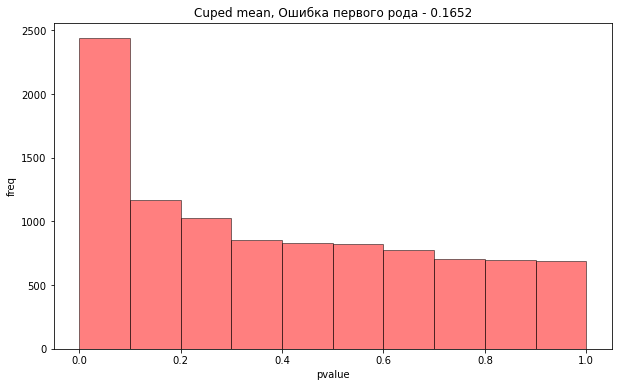

In [29]:
plt.figure(figsize = (10, 6))
plt.hist(pvals_cuped_mean, edgecolor = 'black', color ='r', alpha = 0.5, label = 'cuped_mean')
plt.title(f'Cuped mean, Ошибка первого рода - {np.mean(np.array(pvals_cuped_mean) < 0.05)}')
plt.xlabel('pvalue')
plt.ylabel('freq')
plt.show()

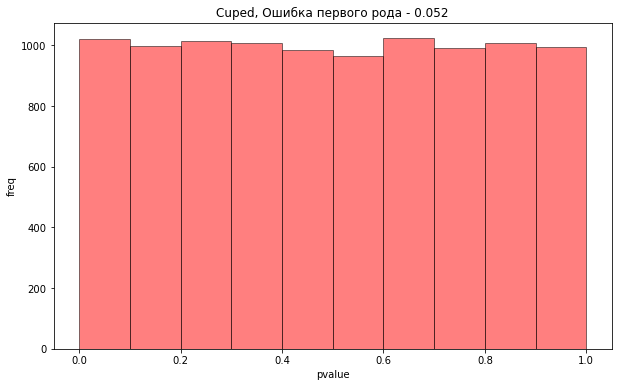

In [30]:
plt.figure(figsize = (10, 6))
plt.hist(pvals_cuped, edgecolor = 'black', color ='r', alpha = 0.5, label = 'cuped', bins = 10)
plt.title(f'Cuped, Ошибка первого рода - {np.mean(np.array(pvals_cuped) < 0.05)}')
plt.xlabel('pvalue')
plt.ylabel('freq')
plt.show()

__В этом случае разница определения ошибок первого рода для CUPED и CUPED Mean__

#### Прогоним через бутстрап наши метрики 

Классический CUPED с предположением на то, что разница значений подходит

In [31]:
def classic_bootstrap(a, b, num_experiments = 1000):
    num_experiments = 1000
    delta_means = []
    for exp in range(num_experiments):
        a_boots = np.random.choice(a, len(a), replace = True)
        b_boots = np.random.choice(b, len(b), replace = True)
        delta_mean = np.mean(b_boots) - np.mean(a_boots)
        delta_means.append(delta_mean)

    std_delta_means = np.std(delta_means)
    true_delta = np.mean(b) - np.mean(a)
    return 2 * (1 - stats.norm.cdf(np.abs(true_delta / std_delta_means)))

In [32]:
pvals = [classic_bootstrap(a_cuped, b_cuped) for i in tqdm(range(1000))]

  0%|          | 0/1000 [00:00<?, ?it/s]

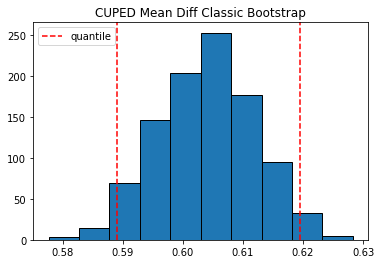

In [33]:
plt.hist(pvals, edgecolor = 'black')
plt.title('CUPED Mean Diff Classic Bootstrap')
plt.axvline(np.quantile(pvals, 0.975), c = 'r', label = 'quantile', linestyle = '--')
plt.axvline(np.quantile(pvals, 0.025), c = 'r', linestyle = '--')
plt.legend();


CUPED с поправкой на среднее по ковариате с предположением на то, что разница значений подходит

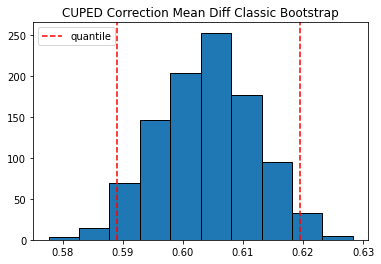

In [34]:
plt.hist(pvals, edgecolor = 'black')
plt.title('CUPED Correction Mean Diff Classic Bootstrap')
plt.axvline(np.quantile(pvals, 0.975), c = 'r', label = 'quantile', linestyle = '--')
plt.axvline(np.quantile(pvals, 0.025), c = 'r', linestyle = '--')
plt.legend();

# нормальное распределение, CUPED ломается о бутстрап

In [35]:
def cuped_bootstrap(a_cuped_mean, b_cuped_mean, num_iterations=1000):

    delta_means = []
    for i in range(num_iterations):
        a_boots = np.random.choice(a_cuped_mean, replace=True, size=len(a_cuped_mean))
        b_boots = np.random.choice(b_cuped_mean, replace=True, size=len(b_cuped_mean))
        delta_mean = np.mean(b_boots) - np.mean(a_boots)
        delta_means.append(delta_mean)

    delta_true = np.mean(b_cuped_mean) - np.mean(a_cuped_mean)
    std_delta_mean = np.std(delta_means)
    
    p_value = 2 * (1 - stats.norm.cdf(np.abs(delta_true) / std_delta_mean))
    
    return p_value


In [36]:
pvals = []
for i in tqdm(range(1000)):
    corr = 0.7
    a_test = np.random.normal(0, 1, size = 1000)
    noise = np.random.normal(0, 1, len(a_test))
    a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

    corr = 0.7
    b_test = np.random.normal(0, 1, size = 1000)
    noise = np.random.normal(0, 1, len(b_test))
    b_before = corr * b_test + np.sqrt(1 - corr**2) * noise
    
    a_cuped_mean, b_cuped_mean, a_cuped, b_cuped = get_cuped_metrics(a_test, b_test, a_before, b_before)
    
    pval = cuped_bootstrap(a_cuped_mean, b_cuped_mean)
    pvals.append(pval)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Скорректированный CUPED.

Ранее была рассмотрена случайная величина и от нее считалась разница ($T' - C'$). Теперь в качестве $\theta$ будем использовать значение метрики до (по группе **A** и по группе **B** вместе), возможно была проблема с тем, что в качестве $\theta$ было использовано некорректное значение

Как это будет выглядеть, предположим у нас есть две случайные величины $ A, A', B, B'$, где $A, B$ - основные метрики, а $A', B'$ - ковариаты

__Введем новые случайные величины:__

$ Z = A \cup B$ 

$ Z' = A' \cup B' $

__Тогда получим, что считаем CUPED следующим образом:__

$Zcuped = Z - \theta * Z $, где $\theta = \dfrac{cov(Z, Z')}{var(Z')} = \dfrac{cov(A \cup B, A' \cup B')}{var(A' \cup B')}$ 

__В данном подходе используется данное изменение для расчета $\theta$ для обеих случайных величин__


Рассчитаем величину $Zcuped$ для двух случайных величин, распределенных по стандартному нормальному распределению с корреляциями 0.7

In [37]:
corr = 0.7
a_test = np.random.normal(0, 1, size = 1000)
noise = np.random.normal(0, 1, len(a_test))
a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

corr = 0.7
b_test = np.random.normal(0, 1, size = 1000)
noise = np.random.normal(0, 1, len(b_test))
b_before = corr * b_test + np.sqrt(1 - corr**2) * noise

In [38]:
theta = np.cov(np.concatenate([a_test, b_test]), np.concatenate([a_before, b_before]))[0][1] / np.var([a_before, b_before])

In [39]:
a_cuped = a_test - theta * a_before
b_cuped = b_test - theta * b_before

### A/A для генерации CUPED и проверка ttest_ind

__Нормальное распределение__

In [40]:
pvals = []
for i in tqdm(range(10000)):
    
    corr = 0.7
    a_test = np.random.normal(100, 20, size = 1000)
    noise = np.random.normal(0, 1, len(a_test))
    a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

    corr = 0.7
    b_test = np.random.normal(100, 20, size = 1000)
    noise = np.random.normal(0, 1, len(b_test))
    b_before = corr * b_test + np.sqrt(1 - corr**2) * noise
    theta = np.cov(np.concatenate([a_test, b_test]), 
                   np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))
    
    a_cuped = a_test - theta * a_before
    b_cuped = b_test - theta * b_before
    
    _, pval = stats.ttest_ind(a_cuped, b_cuped)
    pvals.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

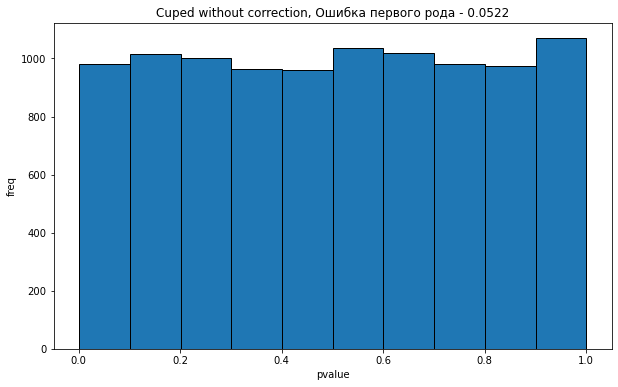

In [41]:
plt.figure(figsize = (10, 6))
plt.hist(pvals, edgecolor = 'black')
plt.title(f'Cuped without correction, Ошибка первого рода - {np.mean(np.array(pvals) < 0.05)}')
plt.xlabel('pvalue')
plt.ylabel('freq')
plt.show()

__Экспоненциальное распределение__

In [42]:
pvals = []
for i in tqdm(range(10000)):
    corr = 0.7
    a_test = np.random.exponential(scale = 1, size = 1000)
    noise = np.random.normal(0, 1, len(a_test))
    a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

    corr = 0.7
    b_test = np.random.exponential(scale = 1, size = 1000)
    noise = np.random.normal(0, 1, len(b_test))
    b_before = corr * b_test + np.sqrt(1 - corr**2) * noise
    theta = np.cov(np.concatenate([a_test, b_test]), 
                   np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))
    
    a_cuped = a_test - (theta * a_before)
    b_cuped = b_test - (theta * b_before)
    
    _, pval = stats.ttest_ind(a_cuped, b_cuped)
    pvals.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

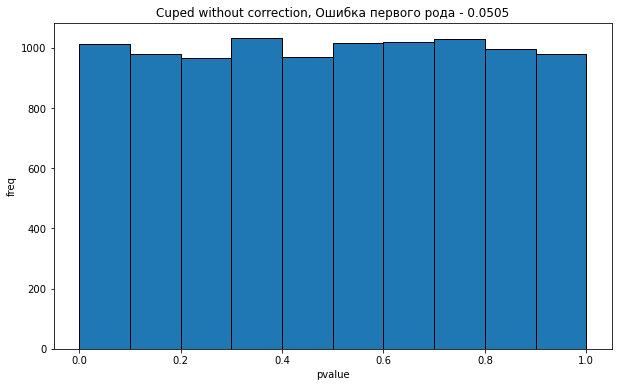

In [43]:
plt.figure(figsize = (10, 6))
plt.hist(pvals, edgecolor = 'black')
plt.title(f'Cuped without correction, Ошибка первого рода - {np.mean(np.array(pvals) < 0.05)}')
plt.xlabel('pvalue')
plt.ylabel('freq')
plt.show()

### A/A для генерации CUPED с коррекцией на среднее и проверка ttest_ind

__Нормальное распределение__

In [44]:
pvals = []
for i in tqdm(range(10000)):
    corr = 0.7
    a_test = np.random.normal(100, 20, size = 1000)
    noise = np.random.normal(0, 1, len(a_test))
    a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

    corr = 0.7
    b_test = np.random.normal(100, 20, size = 1000)
    noise = np.random.normal(0, 1, len(b_test))
    b_before = corr * b_test + np.sqrt(1 - corr**2) * noise
    theta = np.cov(np.concatenate([a_test, b_test]), 
                   np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))
    
    a_cuped = a_test - (theta * a_before - theta * np.mean(np.concatenate([a_before, b_before])))
    b_cuped = b_test - (theta * b_before - theta * np.mean(np.concatenate([a_before, b_before])))
    
    _, pval = stats.ttest_ind(a_cuped, b_cuped)
    pvals.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

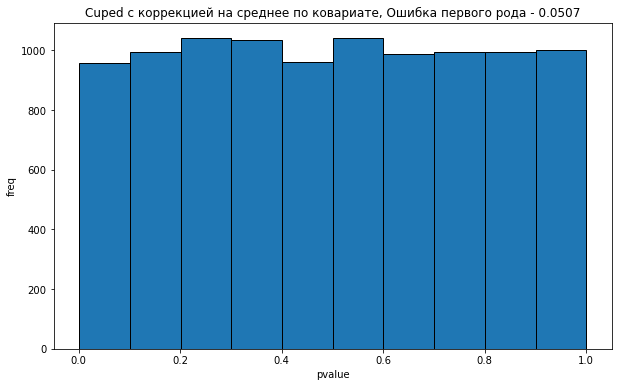

In [45]:
plt.figure(figsize = (10, 6))
plt.hist(pvals, edgecolor = 'black')
plt.title(f'Cuped с коррекцией на среднее по ковариате, Ошибка первого рода - {np.mean(np.array(pvals) < 0.05)}')
plt.xlabel('pvalue')
plt.ylabel('freq')
plt.show()

__Экспоненциальное распределение__

In [46]:
pvals = []
for i in tqdm(range(10000)):
    corr = 0.7
    a_test = np.random.exponential(scale = 1, size = 1000)
    noise = np.random.normal(0, 1, len(a_test))
    a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

    corr = 0.7
    b_test = np.random.exponential(scale = 1, size = 1000)
    noise = np.random.normal(0, 1, len(b_test))
    b_before = corr * b_test + np.sqrt(1 - corr**2) * noise
    theta = np.cov(np.concatenate([a_test, b_test]), 
                   np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))
    
    a_cuped = a_test - (theta * a_before - theta * np.mean(np.concatenate([a_before, b_before])))
    b_cuped = b_test - (theta * b_before - theta * np.mean(np.concatenate([a_before, b_before])))
    
    _, pval = stats.ttest_ind(a_cuped, b_cuped)
    pvals.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

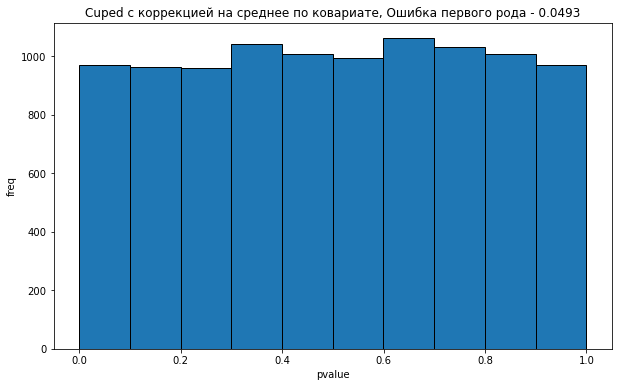

In [47]:
plt.figure(figsize = (10, 6))
plt.hist(pvals, edgecolor = 'black')
plt.title(f'Cuped с коррекцией на среднее по ковариате, Ошибка первого рода - {np.mean(np.array(pvals) < 0.05)}')
plt.xlabel('pvalue')
plt.ylabel('freq')
plt.show()

#### Для нормального распределения можем оценить границы применимости 

1. Как размер выборки влияет на определение ошибки первого рода (сходимость ошибки первого рода при минимальной дисперсии и среднем)?
2. Как параметры распределения могут влиять на определение ошибки первого рода?
3. Как мощность изменяется? Оценка MDE

### Симуляция распределений p-value при увеличении среднего в выборке b

__Нормальное распределение__

0it [00:00, ?it/s]

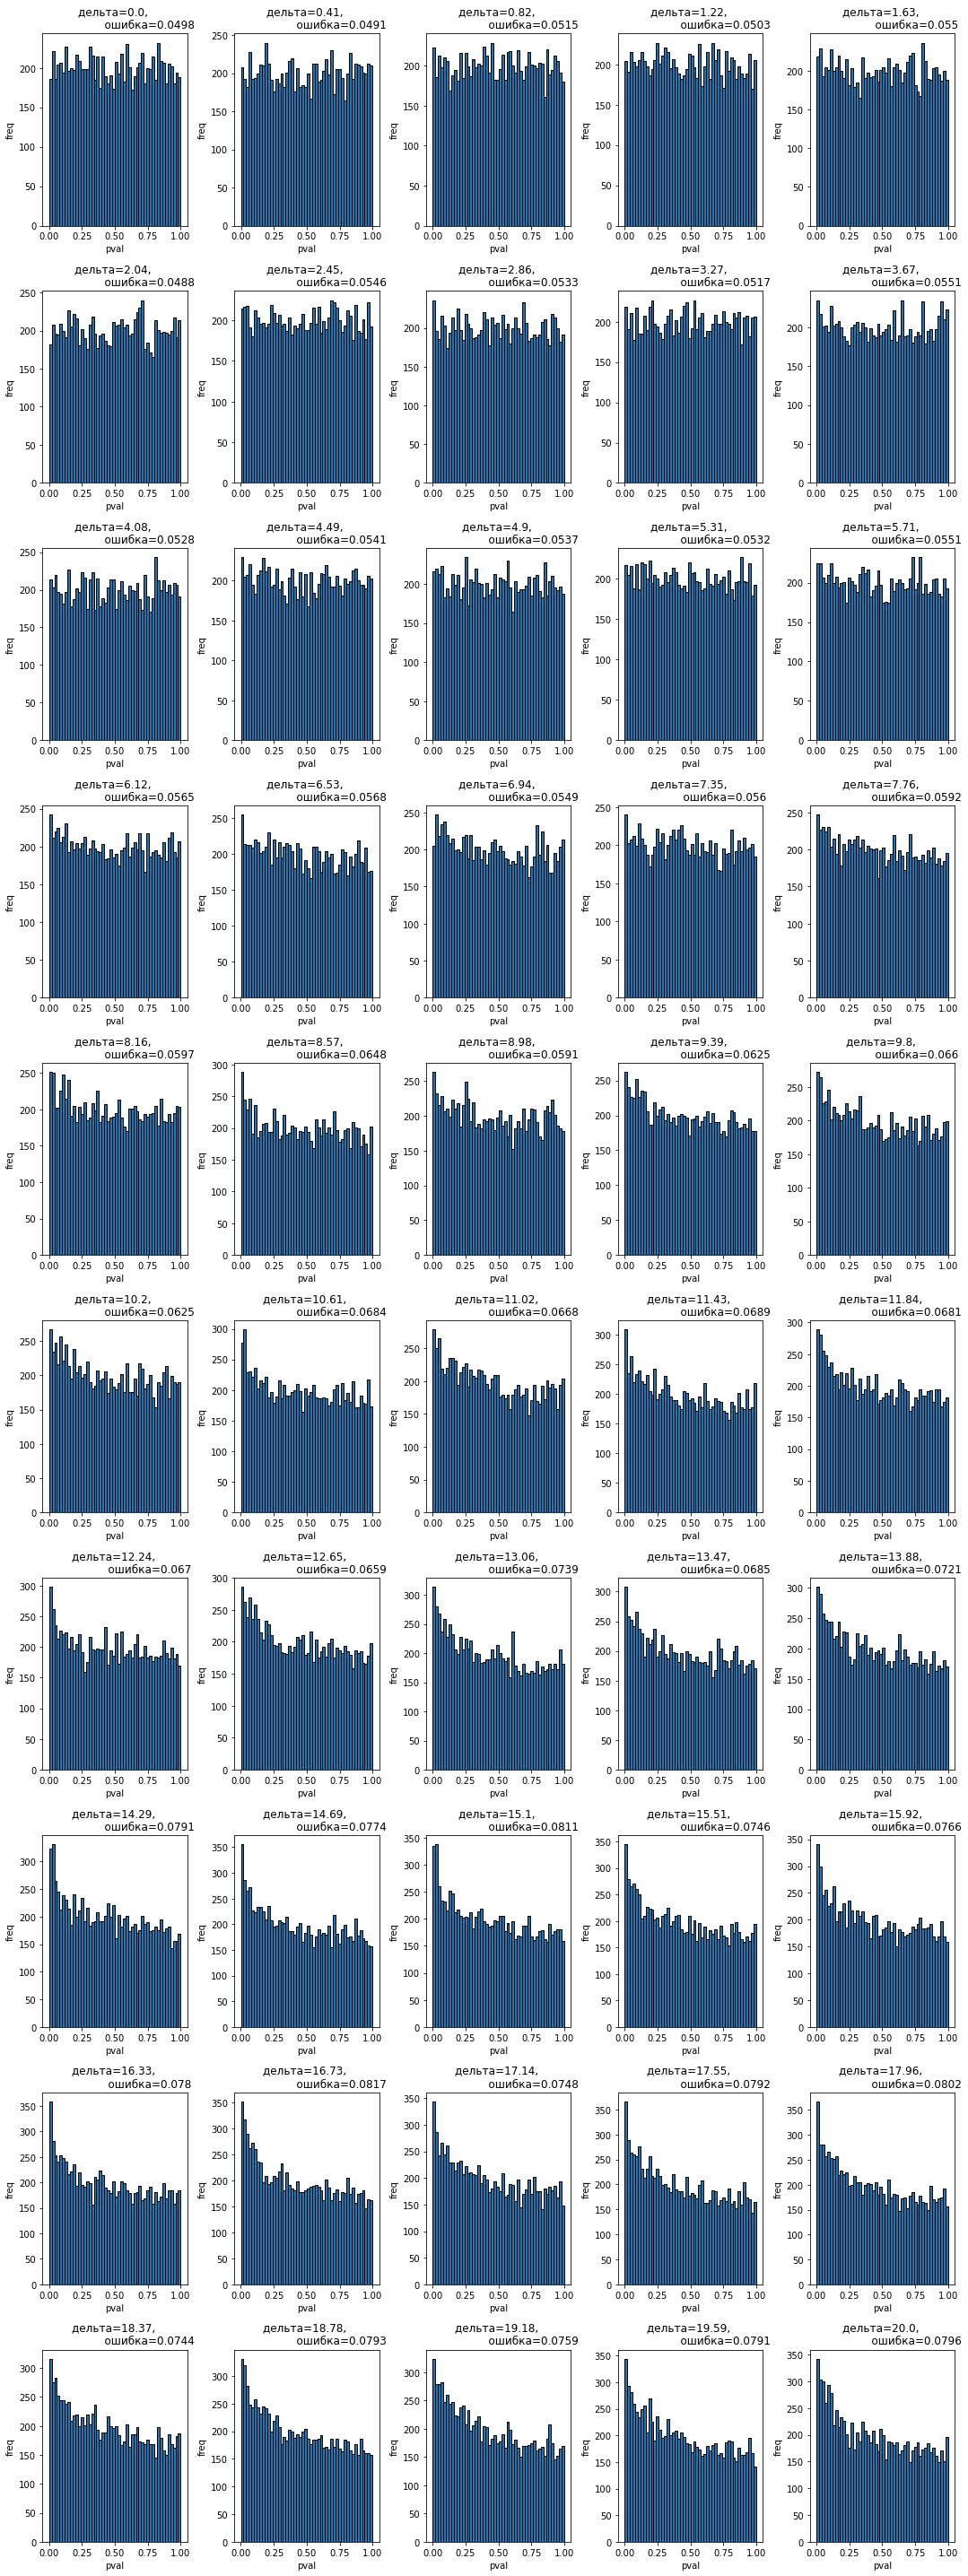

In [48]:
num_subplots = 50

num_rows, num_cols = divmod(num_subplots, 5)

if num_cols > 0:
    num_rows += 1

fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(15, 4 * num_rows))
axes = axes.flatten()

deltas = np.linspace(0, 20, num_subplots)  

for delta, ax in tqdm(zip(deltas, axes)):
    pvals = []
    for i in range(10000):
        corr = 0.7
        a_test = np.random.normal(100, 20, size=1000)
        noise = np.random.normal(0, 1, len(a_test))
        a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

        corr = 0.7
        b_test = np.random.normal(100 + delta, 20, size=1000)  
        noise = np.random.normal(0, 1, len(b_test))
        b_before = corr * b_test + np.sqrt(1 - corr**2) * noise

        theta = np.cov(np.concatenate([a_test, b_test]),
                       np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))

        a_cuped = a_test - theta * a_before
        b_cuped = b_test - theta * b_before

        _, pval = stats.ttest_ind(a_cuped, b_cuped)
        pvals.append(pval)

    ax.hist(pvals, bins=50, edgecolor='black')
    ax.set_title(f"""дельта={np.round(delta, 2)}, 
                    ошибка={np.mean(np.array(pvals) < 0.05)}""")
    ax.set_xlabel('pval')
    ax.set_ylabel('freq')

plt.tight_layout()
plt.show()


__Изменим максимум $\delta$ на 100 вместо 20__.

0it [00:00, ?it/s]

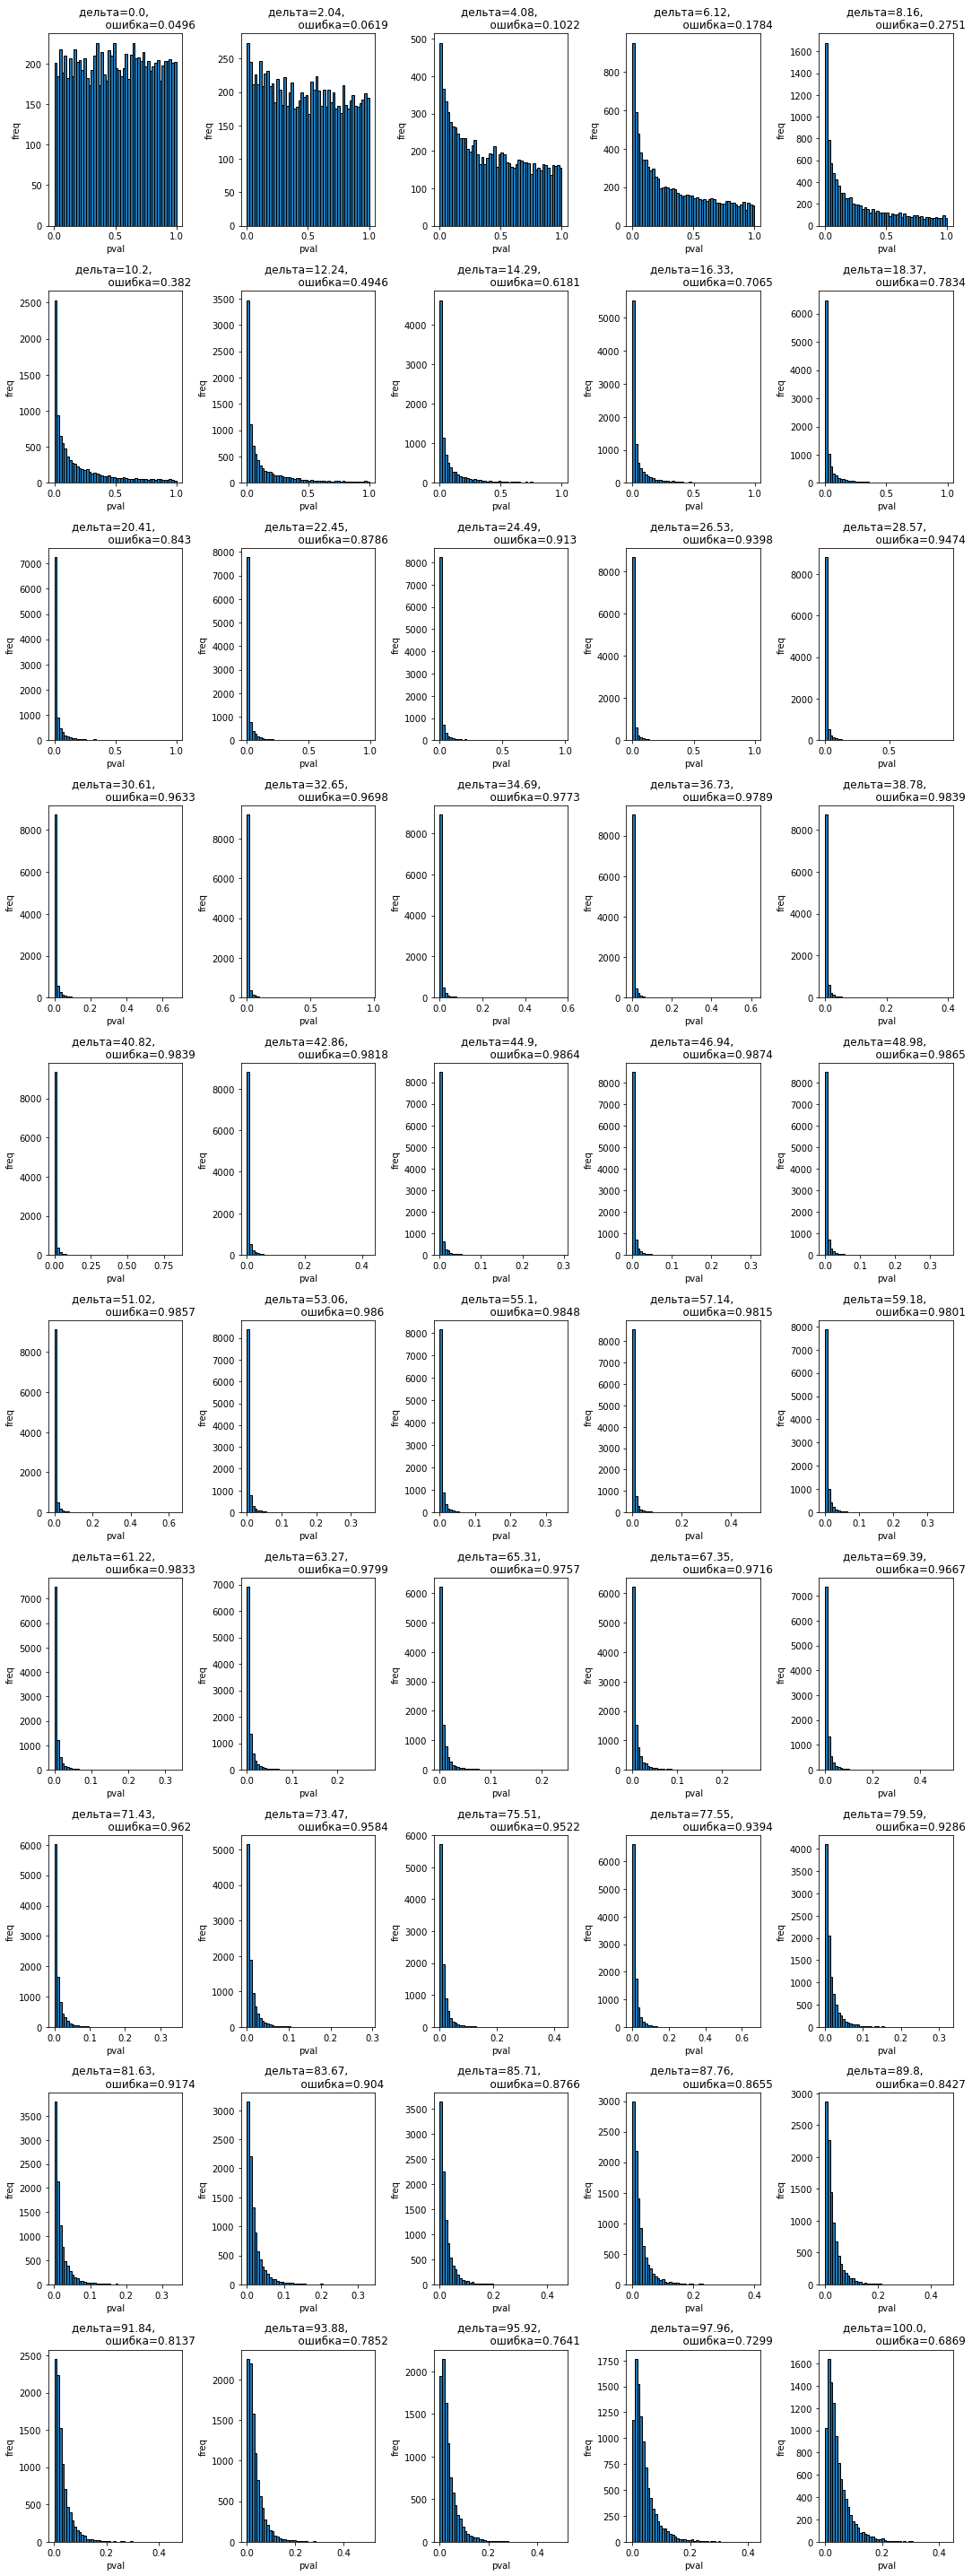

In [49]:
num_subplots = 50

num_rows, num_cols = divmod(num_subplots, 5)

if num_cols > 0:
    num_rows += 1

fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(15, 4 * num_rows))
axes = axes.flatten()

deltas = np.linspace(0, 100, num_subplots)  

for delta, ax in tqdm(zip(deltas, axes)):
    pvals = []
    for i in range(10000):
        corr = 0.7
        a_test = np.random.normal(100, 20, size=10000)
        noise = np.random.normal(0, 1, len(a_test))
        a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

        corr = 0.7
        b_test = np.random.normal(100 + delta, 20, size=10000)  
        noise = np.random.normal(0, 1, len(b_test))
        b_before = corr * b_test + np.sqrt(1 - corr**2) * noise

        theta = np.cov(np.concatenate([a_test, b_test]),
                       np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))

        a_cuped = a_test - theta * a_before
        b_cuped = b_test - theta * b_before

        _, pval = stats.ttest_ind(a_cuped, b_cuped)
        pvals.append(pval)

    ax.hist(pvals, bins=50, edgecolor='black')
    ax.set_title(f"""дельта={np.round(delta, 2)}, 
                    ошибка={np.mean(np.array(pvals) < 0.05)}""")
    ax.set_xlabel('pval')
    ax.set_ylabel('freq')

plt.tight_layout()
plt.show()


# при увеличении Delta мы теряем мощность, почему? (ответ ниже)

Рассчитаем $MDE$, чтобы понять, где мы можем поймать эффект при заданных параметрах $\alpha$, $\beta$, $\sigma_a$, $\sigma_b$

In [50]:
corr = 0.7
a_test = np.random.normal(100, 20, size=10000)
noise = np.random.normal(0, 1, len(a_test))
a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

corr = 0.7
b_test = np.random.normal(100 + delta, 20, size=10000)  
noise = np.random.normal(0, 1, len(b_test))
b_before = corr * b_test + np.sqrt(1 - corr**2) * noise

theta = np.cov(np.concatenate([a_test, b_test]),
               np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))

a_cuped = a_test - theta * a_before
b_cuped = b_test - theta * b_before

In [51]:
delta = get_mde(a_cuped, b_cuped)
delta

0.04072199089332313

In [52]:
pvals = []
for i in tqdm(range(10000)):
    corr = 0.7
    a_test = np.random.normal(100, 20, size=10000)
    noise = np.random.normal(0, 1, len(a_test))
    a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

    corr = 0.7
    b_test = np.random.normal(100, 20, size=10000)  
    noise = np.random.normal(0, 1, len(b_test))
    b_before = corr * b_test + np.sqrt(1 - corr**2) * noise

    theta = np.cov(np.concatenate([a_test, b_test]),
                   np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))

    a_cuped = a_test - theta * a_before
    b_cuped = b_test - theta * b_before

    _, pval = stats.ttest_ind(a_cuped, b_cuped)
    pvals.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

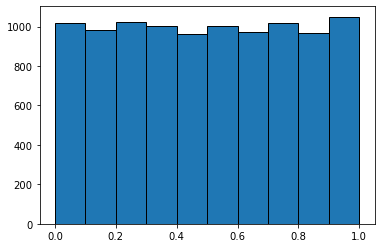

In [53]:
# если мы применяем MDE к основной метрике, результата не будет, нужно менять конечную метрику, 
# т.к. на основной это уже никак не скажется, при увеличении 
plt.hist(pvals, edgecolor = 'black');

Добавим $\delta$ к $Bcuped$

In [54]:
pvals = []
for i in tqdm(range(10000)):
    corr = 0.7
    a_test = np.random.normal(100, 20, size=10000)
    noise = np.random.normal(0, 1, len(a_test))
    a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

    corr = 0.7
    b_test = np.random.normal(100, 20, size=10000)  
    noise = np.random.normal(0, 1, len(b_test))
    b_before = corr * b_test + np.sqrt(1 - corr**2) * noise

    theta = np.cov(np.concatenate([a_test, b_test]),
                   np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))

    a_cuped = a_test - theta * a_before
    b_cuped = b_test - theta * b_before + delta 

    _, pval = stats.ttest_ind(a_cuped, b_cuped)
    pvals.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

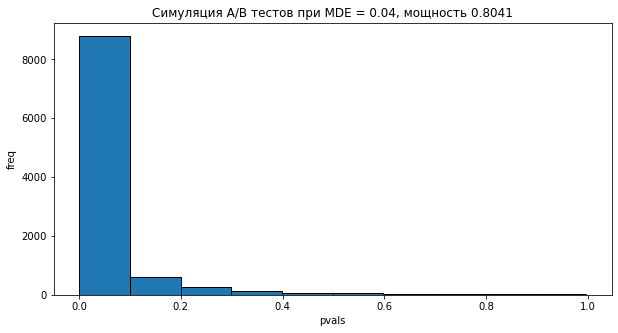

In [55]:
plt.figure(figsize = (10, 5))
plt.title(f'Симуляция A/B тестов при MDE = {np.round(delta, 2)}, мощность {np.mean(np.array(pvals) < 0.05)}')
plt.hist(pvals,edgecolor = 'black')
plt.xlabel('pvals')
plt.ylabel('freq');

__Изменим подход, теперь $\delta$ будет добавляться не к основной метрике, а к CUPED преобразованной__

0it [00:00, ?it/s]

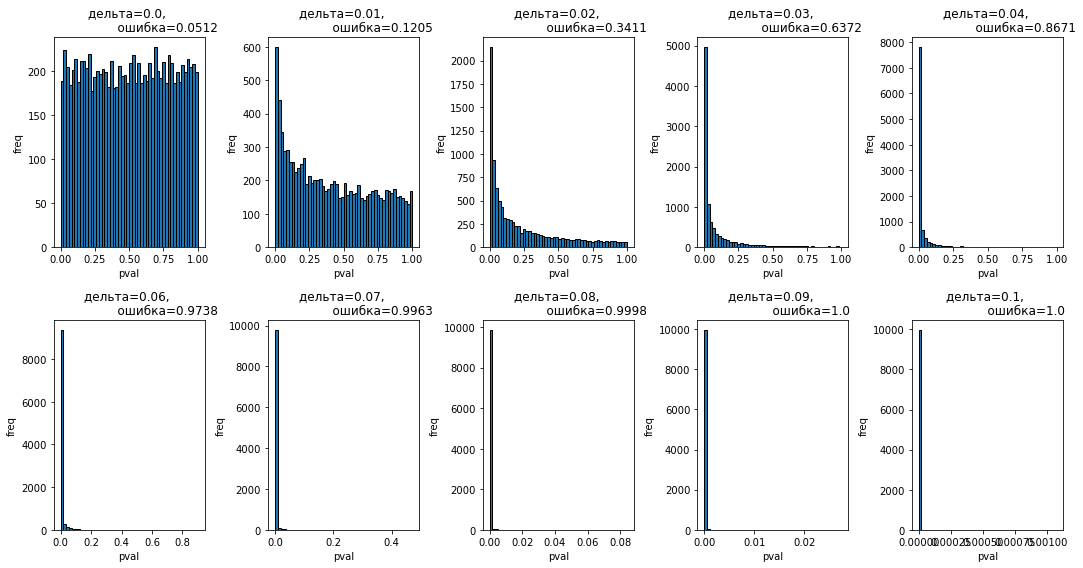

In [56]:
num_subplots = 10

num_rows, num_cols = divmod(num_subplots, 5)

if num_cols > 0:
    num_rows += 1

fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(15, 4 * num_rows))
axes = axes.flatten()

deltas = np.linspace(0, 0.1, num_subplots)  

for delta, ax in tqdm(zip(deltas, axes)):
    pvals = []
    for i in range(10000):
        corr = 0.7
        a_test = np.random.normal(100, 20, size=10000)
        noise = np.random.normal(0, 1, len(a_test))
        a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

        corr = 0.7
        b_test = np.random.normal(100, 20, size=10000)  
        noise = np.random.normal(0, 1, len(b_test))
        b_before = corr * b_test + np.sqrt(1 - corr**2) * noise

        theta = np.cov(np.concatenate([a_test, b_test]),
                       np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))

        a_cuped = a_test - theta * a_before
        b_cuped = b_test - theta * b_before + delta

        _, pval = stats.ttest_ind(a_cuped, b_cuped)
        pvals.append(pval)

    ax.hist(pvals, bins=50, edgecolor='black')
    ax.set_title(f"""дельта={np.round(delta, 2)}, 
                    ошибка={np.mean(np.array(pvals) < 0.05)}""")
    ax.set_xlabel('pval')
    ax.set_ylabel('freq')

plt.tight_layout()
plt.show()

# видим, что на дельта = 0.4 ошибка первого рода определяется, теперь посмотрим, 
# в качестве примера посмотрим на a_test, b_test и их MDE
# также видно, что матожидания должны быть ровны у двух групп, поскольку далее ошибка первго рода увеличивается
# здесь может быть такое условие

__Условие на то, что при $A$ и $B$ (коваритиам) должно быть выполнено следующее $E(A) = E(B)$__
Сгенерируем распределения, но при этом матожидания ковариат будут различаться.

__По свойству матожидания__
$E(B + bias) = E(B) + E(bias) = E(B) + bias $, отсюда матожидания будут различаться (у ковариат).

__При увеличении дельта видно, что у CUPED есть ограничения, матожидания должны быть равны__

0it [00:00, ?it/s]

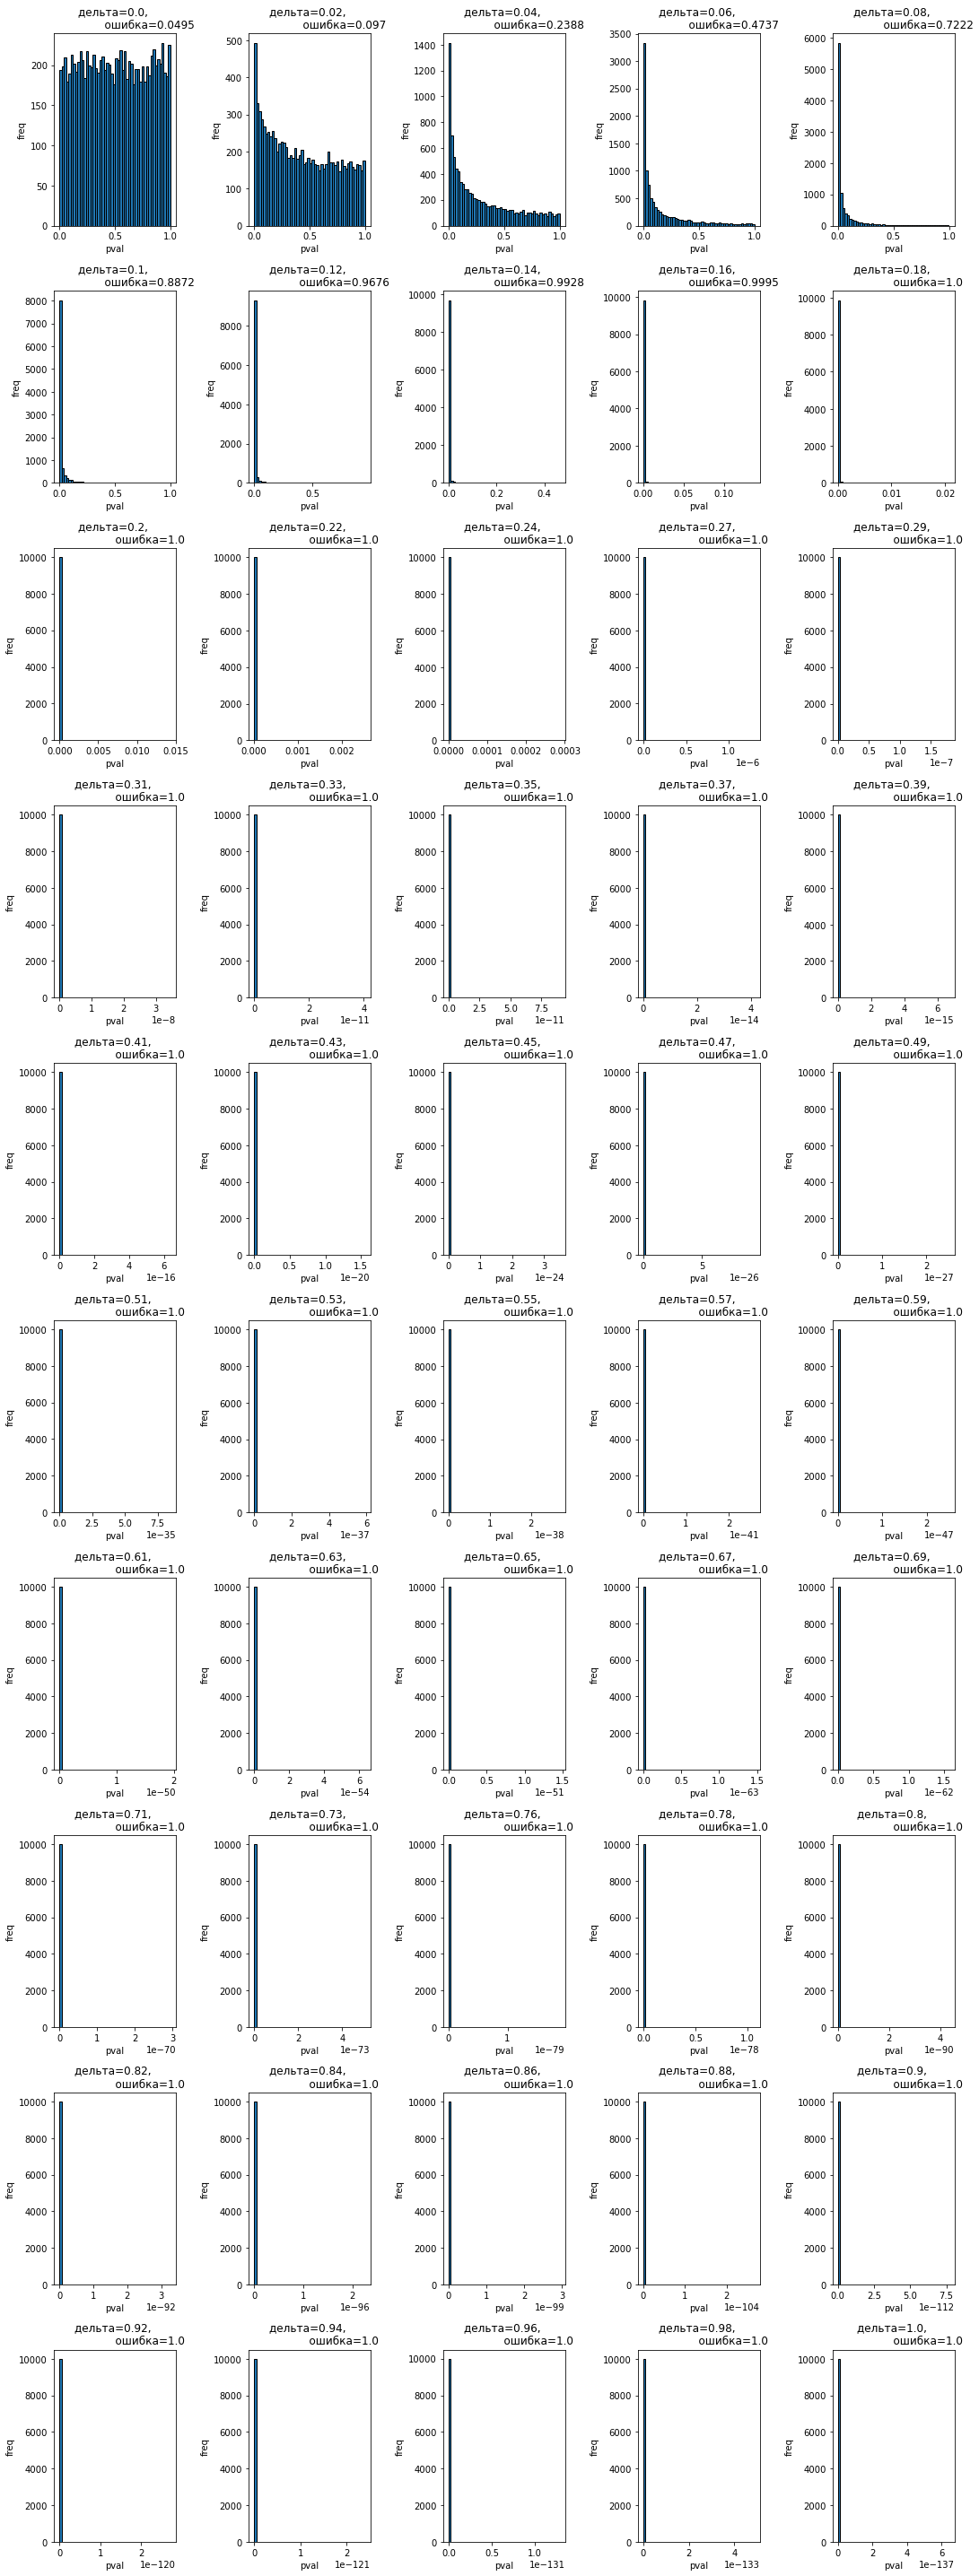

In [57]:
num_subplots = 50

num_rows, num_cols = divmod(num_subplots, 5)

if num_cols > 0:
    num_rows += 1

fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(15, 4 * num_rows))
axes = axes.flatten()

biases = np.linspace(0, 1, num_subplots)  

for bias, ax in tqdm(zip(biases, axes)):
    pvals = []
    for i in range(10000):
        corr = 0.7
        a_test = np.random.normal(100, 20, size=1000)
        noise = np.random.normal(0, 1, len(a_test))
        a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

        corr = 0.7
        b_test = np.random.normal(100, 20, size=1000)  
        noise = np.random.normal(0, 1, len(b_test))
        b_before = corr * b_test + np.sqrt(1 - corr**2) * noise + bias

        theta = np.cov(np.concatenate([a_test, b_test]),
                       np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))

        a_cuped = a_test - theta * a_before
        b_cuped = b_test - theta * b_before

        _, pval = stats.ttest_ind(a_cuped, b_cuped)
        pvals.append(pval)

    ax.hist(pvals, bins=50, edgecolor='black')
    ax.set_title(f"""дельта={np.round(bias, 2)}, 
                    ошибка={np.mean(np.array(pvals) < 0.05)}""")
    ax.set_xlabel('pval')
    ax.set_ylabel('freq')

plt.tight_layout()
plt.show()


In [58]:
get_mde(a_test, b_test)
# для a_test, b_test MDE = 0.8, в этом случае мы сократили дисперсию значительно, проверим так ли это на генерации

2.4895823929148744

0it [00:00, ?it/s]

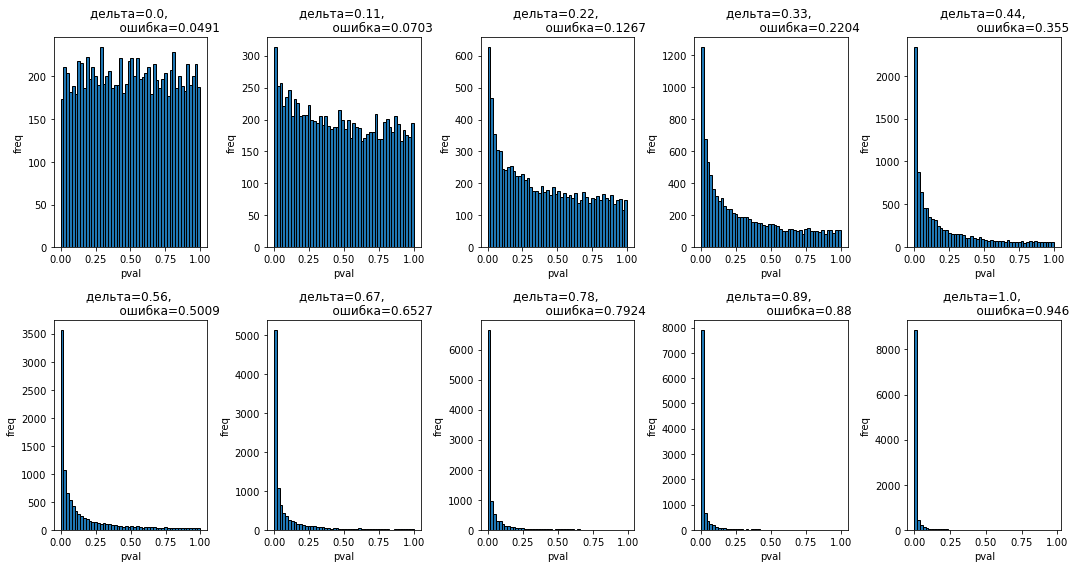

In [59]:
num_subplots = 10

num_rows, num_cols = divmod(num_subplots, 5)

if num_cols > 0:
    num_rows += 1

fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(15, 4 * num_rows))
axes = axes.flatten()

deltas = np.linspace(0, 1, num_subplots)  

for delta, ax in tqdm(zip(deltas, axes)):
    pvals = []
    for i in range(10000):

        a_test = np.random.normal(100, 20, size=10000)
        b_test = np.random.normal(100 + delta, 20, size=10000)  

        _, pval = stats.ttest_ind(a_test, b_test)
        pvals.append(pval)

    ax.hist(pvals, bins=50, edgecolor='black')
    ax.set_title(f"""дельта={np.round(delta, 2)}, 
                    ошибка={np.mean(np.array(pvals) < 0.05)}""")
    ax.set_xlabel('pval')
    ax.set_ylabel('freq')

plt.tight_layout()
plt.show()

# видим, что на дельта = 0.4 ошибка первого рода определяется, теперь посмотрим, 
# в качестве примера посмотрим на a_test, b_test и их MDE

# как раз получилось то, что различие в выборках мы детектируем значительно раньше при CUPED, разница в 20 раз по дельте!!!

__Тест с отношением $\dfrac {\sigma_b}{\sigma_a}$.__
Предположим, что у нас изменилась дисперсия для группы ${b}$ по сравнению со статичной группой ${a}$. Посмотрим как это влияет на ошибки. Также дополнительно рассмотрим $\rho$ (корреляцию между ковариатой и основной метрикой), посмотрим как это влияет на результаты теста. В качестве изменений на 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

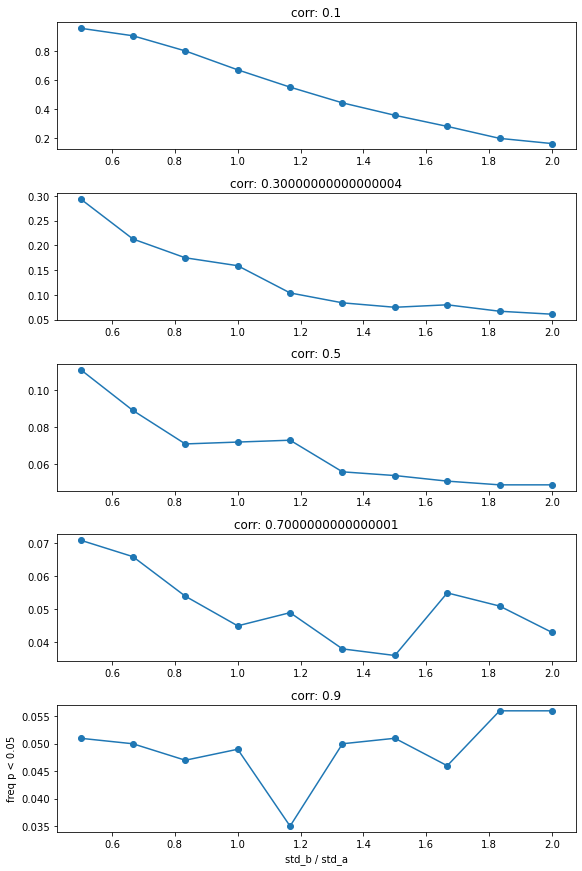

In [60]:
num_simulations = 1000
sample_size = 1000
effect_size = 5

def cuped_simulation(corr, sigma_ratio, effect_size):
    pvals = []
    for i in range(num_simulations):
        a_test = np.random.normal(100, 20, size=sample_size)
        noise = np.random.normal(0, 1, len(a_test))
        a_before = corr * a_test + np.sqrt(1 - corr**2) * noise

        b_test = np.random.normal(100 + effect_size, 20 * sigma_ratio, size=sample_size)
        noise = np.random.normal(0, 1, len(b_test))
        b_before = corr * b_test + np.sqrt(1 - corr**2) * noise

        theta = np.cov(np.concatenate([a_test, b_test]),
                       np.concatenate([a_before, b_before]))[0][1] / np.var(np.concatenate([a_before, b_before]))

        a_cuped = a_test - theta * a_before
        b_cuped = b_test - theta * b_before

        _, pval = stats.ttest_ind(a_cuped, b_cuped)
        pvals.append(pval)
    return np.mean(np.array(pvals) < 0.05)


sigma_ratios = np.linspace(0.5, 2, 10)
corrs = np.linspace(0.1, 0.9, 5)

fig, axes = plt.subplots(nrows=len(corrs), ncols=1, figsize=(8, 12))
axes = axes.flatten()

for i, corr in enumerate(corrs):
    success_rates = []
    for sigma_ratio in tqdm(sigma_ratios):
        success_rate = cuped_simulation(corr, sigma_ratio, effect_size)
        success_rates.append(success_rate)

    axes[i].plot(sigma_ratios, success_rates, marker='o')
    axes[i].set_title(f"corr: {corr}")

plt.tight_layout()
plt.xlabel("std_b / std_a")
plt.ylabel("freq p < 0.05")
plt.show()

__При повышении корреляции между основной метрикой и коваритой задетектировать эффект (при его наличии в основной метрике)__
__становится сложней, также на детектирование эффекта влияет и отношение дисперсий, чем больше, тем сложнее задетектировать__